In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


## Specify dataset

In [92]:
np.arange(0, 1.1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [93]:
feature_maker_kwargs = {
    'feature_dim': 64, 'feature_vals': None,
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.25
    }
feature_maker_kwargs = {
    'feature_dim': 64,
    'feature_vals': np.arange(0, 1.1,0.1),
    'feature_vals_p': [1./11]*11
    }
dataset_config = {
    'num_steps': 2000, 'num_states': 64,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk
input_size = feature_maker_kwargs['feature_dim']
seed = 3

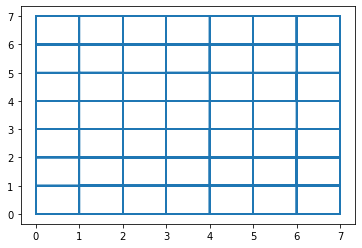

In [94]:
np.random.seed(seed)
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

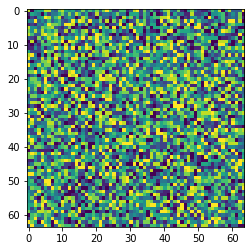

In [95]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [104]:
gamma=0.6

# Plot RNN outputs

In [110]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        'eigenval_offset': 0.4
        }
    )
np.random.seed(seed)
outputs, loss = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma
    )


[   51] loss: 0.095
Time per step 0.002s, net 0.093s

[  101] loss: 0.057
Time per step 0.003s, net 0.224s

[  151] loss: 0.042
Time per step 0.004s, net 0.406s

[  201] loss: 0.039
Time per step 0.004s, net 0.629s

[  251] loss: 0.038
Time per step 0.005s, net 0.892s

[  301] loss: 0.038
Time per step 0.007s, net 1.217s

[  351] loss: 0.038
Time per step 0.007s, net 1.586s

[  401] loss: 0.039
Time per step 0.009s, net 2.054s

[  451] loss: 0.039
Time per step 0.010s, net 2.534s

[  501] loss: 0.039
Time per step 0.010s, net 3.055s

[  551] loss: 0.040
Time per step 0.011s, net 3.615s

[  601] loss: 0.040
Time per step 0.015s, net 4.388s

[  651] loss: 0.039
Time per step 0.013s, net 5.025s

[  701] loss: 0.040
Time per step 0.014s, net 5.706s

[  751] loss: 0.041
Time per step 0.016s, net 6.505s

[  801] loss: 0.040
Time per step 0.016s, net 7.281s

[  851] loss: 0.040
Time per step 0.017s, net 8.108s

[  901] loss: 0.040
Time per step 0.019s, net 9.036s

[  951] loss: 0.039
Time pe

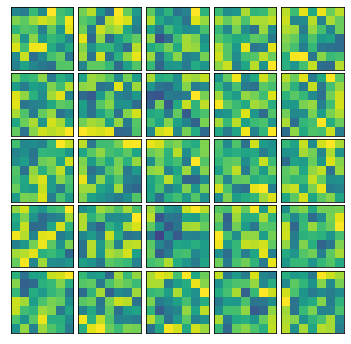

In [111]:
import matplotlib.gridspec as gridspec

grid_x = 5; grid_y = 5;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

In [ ]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur].numpy())
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 

# Plot Linear outputs

In [98]:
linear = Linear(input_size=input_size)
np.random.seed(seed)
outputs, loss = run_linear(
    '../trained_models/test/', linear, dataset,
    dataset_config, gamma=gamma, lr=1E-3
    )


[   51] loss: 0.326
Time per step 0.001s, net 0.043s

[  101] loss: 0.308
Time per step 0.002s, net 0.124s

[  151] loss: 0.294
Time per step 0.002s, net 0.233s

[  201] loss: 0.285
Time per step 0.003s, net 0.377s

[  251] loss: 0.278
Time per step 0.004s, net 0.575s

[  301] loss: 0.273
Time per step 0.005s, net 0.831s

[  351] loss: 0.272
Time per step 0.005s, net 1.080s

[  401] loss: 0.274
Time per step 0.006s, net 1.372s

[  451] loss: 0.274
Time per step 0.007s, net 1.698s

[  501] loss: 0.278
Time per step 0.007s, net 2.064s

[  551] loss: 0.289
Time per step 0.010s, net 2.577s

[  601] loss: 0.297
Time per step 0.010s, net 3.097s

[  651] loss: 0.301
Time per step 0.011s, net 3.663s

[  701] loss: 0.309
Time per step 0.012s, net 4.268s

[  751] loss: 0.314
Time per step 0.013s, net 4.922s

[  801] loss: 0.320
Time per step 0.015s, net 5.664s

[  851] loss: 0.327
Time per step 0.017s, net 6.499s

[  901] loss: 0.336
Time per step 0.016s, net 7.284s

[  951] loss: 0.343
Time pe

KeyboardInterrupt: 

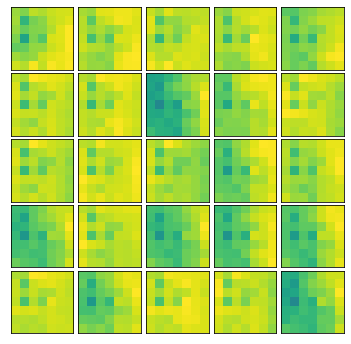

In [99]:
import matplotlib.gridspec as gridspec

grid_x = 5; grid_y = 5;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

In [ ]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 

# Plot MLP outputs

In [100]:
mlp = MLP(input_size=input_size, hidden_size=input_size*2)
np.random.seed(seed)
outputs, loss = run_mlp(
    '../trained_models/test/', mlp, dataset,
    dataset_config, gamma=gamma
    )


[   51] loss: 0.294
Time per step 0.002s, net 0.107s

[  101] loss: 0.116
Time per step 0.002s, net 0.214s

[  151] loss: 0.063
Time per step 0.002s, net 0.334s

[  201] loss: 0.115
Time per step 0.003s, net 0.460s

[  251] loss: 0.068
Time per step 0.003s, net 0.588s

[  301] loss: 0.065
Time per step 0.003s, net 0.740s

[  351] loss: 0.060
Time per step 0.003s, net 0.900s

[  401] loss: 0.094
Time per step 0.003s, net 1.070s

[  451] loss: 0.076
Time per step 0.003s, net 1.237s

[  501] loss: 0.068
Time per step 0.003s, net 1.398s

[  551] loss: 0.072
Time per step 0.004s, net 1.580s

[  601] loss: 0.075
Time per step 0.004s, net 1.761s

[  651] loss: 0.069
Time per step 0.004s, net 1.942s

[  701] loss: 0.067
Time per step 0.004s, net 2.137s

[  751] loss: 0.063
Time per step 0.004s, net 2.344s

[  801] loss: 0.061
Time per step 0.006s, net 2.622s

[  851] loss: 0.061
Time per step 0.005s, net 2.861s

[  901] loss: 0.060
Time per step 0.005s, net 3.091s

[  951] loss: 0.059
Time pe

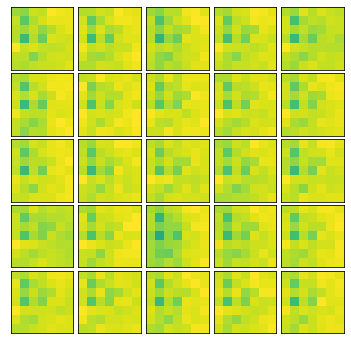

In [101]:
import matplotlib.gridspec as gridspec

grid_x = 5; grid_y = 5;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

In [ ]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)
for neur in range(outputs.shape[1]):
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0
    plt.figure()
    plt.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    plt.colorbar()
    plt.show() 